# **Final Python Notebook 3: Regression DT and Ensemble Learners**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

----------PART 1: Voting Ensemble Classifier (Mortality Status Prediction)----------

In [2]:
# Loading the prepared Classification Dataset
classification_df = pd.read_csv('Classification Dataset.csv')

In [35]:
classification_df.head()

,Age,Sex,Occupation,T_Stage,N_Stage,6th_Stage,Differentiated,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Mortality_Status
0,68.0,Female,Teaching,T1,N1,IIA,Poorly differentiated,3,Regional,4.0,Positive,Positive,24.0,1,Alive
1,50.0,Female,Medical,T2,N2,IIIA,Moderately differentiated,2,Regional,35.0,Positive,Positive,14.0,5,Alive
2,58.0,Female,Engineering,T3,N3,IIIC,Moderately differentiated,2,Regional,63.0,Positive,Positive,14.0,7,Alive
3,58.0,Female,Technology,T1,N1,IIA,Poorly differentiated,3,Regional,18.0,Positive,Positive,2.0,1,Alive
4,47.0,Female,Multimedia,T2,N1,IIB,Poorly differentiated,3,Regional,41.0,Positive,Positive,3.0,1,Alive


In [3]:
# Splitting features and target
X = classification_df.drop('Mortality_Status', axis=1)
y = classification_df['Mortality_Status']

----------Encoding Categorical Features----------

In [4]:
# Create LabelEncoder object
le = LabelEncoder()

In [5]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [6]:
# Apply label encoding to each categorical feature
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [7]:
# Encode the target if needed
if y.dtype == 'object':
    y = le.fit_transform(y)

----------Handling classes with very few samples----------

In [8]:
# Checking class distribution
class_counts = pd.Series(y).value_counts()

In [9]:
# Keep only classes with at least 2 samples
valid_classes = class_counts[class_counts > 1].index

In [10]:
# Filtering
X = X[pd.Series(y).isin(valid_classes)]
y = pd.Series(y)[pd.Series(y).isin(valid_classes)]

----------Train-Test Split----------

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (2816, 14)
Testing Features Shape: (1207, 14)


---------Building Voting Classifier----------

In [12]:
# Base learners
lr_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier(n_neighbors=5)

In [13]:
# Creating Voting Classifier (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('knn', knn_model)
    ],
    voting='soft'
)

In [14]:
# Training Voting Classifier
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [15]:
# Predicting with Voting Classifier
y_pred_voting = voting_clf.predict(X_test)

In [16]:
# Evaluating Voting Classifier
print("Voting Classifier Report:")
print(classification_report(y_test, y_pred_voting))

Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.85      0.99      0.92      1020
           3       0.00      0.00      0.00         3
           4       0.53      0.06      0.10       179
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2

    accuracy                           0.85      1207
   macro avg       0.23      0.17      0.17      1207
weighted avg       0.80      0.85      0.79      1207



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# ROC AUC Score for Voting Classifier
roc_auc_voting = roc_auc_score(y_test, voting_clf.predict_proba(X_test), multi_class='ovr')
print("Voting Classifier ROC AUC Score:", roc_auc_voting)

Voting Classifier ROC AUC Score: 0.7378985120514129


----------PART 2: Decision Tree Regression (Predicting Survival Months)----------

In [18]:
# Loading the prepared Regression Dataset
regression_df = pd.read_csv('Regression Dataset.csv')

In [36]:
regression_df.head()

,Age,Sex,Occupation,T_Stage,N_Stage,6th_Stage,Differentiated,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Survival_Months
0,68.0,Female,Teaching,T1,N1,IIA,Poorly differentiated,3,Regional,4.0,Positive,Positive,24.0,1,60
1,50.0,Female,Medical,T2,N2,IIIA,Moderately differentiated,2,Regional,35.0,Positive,Positive,14.0,5,62
2,58.0,Female,Engineering,T3,N3,IIIC,Moderately differentiated,2,Regional,63.0,Positive,Positive,14.0,7,75
3,58.0,Female,Technology,T1,N1,IIA,Poorly differentiated,3,Regional,18.0,Positive,Positive,2.0,1,84
4,47.0,Female,Multimedia,T2,N1,IIB,Poorly differentiated,3,Regional,41.0,Positive,Positive,3.0,1,50


In [19]:
# Splitting features and target
X_reg = regression_df.drop('Survival_Months', axis=1)
y_reg = regression_df['Survival_Months']

------------Encoding Categorical Features in Regression Dataset-----------

In [20]:
# Identify categorical columns
categorical_cols_reg = X_reg.select_dtypes(include=['object']).columns

In [21]:
# Apply label encoding
for col in categorical_cols_reg:
    X_reg[col] = le.fit_transform(X_reg[col])

----------rain-Test Split for Regression----------

In [22]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg,
    test_size=0.3,
    random_state=42
)

print("Training Features Shape (Regression):", X_reg_train.shape)
print("Testing Features Shape (Regression):", X_reg_test.shape)

Training Features Shape (Regression): (2816, 14)
Testing Features Shape (Regression): (1208, 14)


 ----------Building Decision Tree 1 (Fully Grown)----------

In [23]:
# Fully-grown Decision Tree Regressor
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(X_reg_train, y_reg_train)

DecisionTreeRegressor(random_state=42)

In [24]:
# Predictions with DT-1
y_pred_dt1 = dt1.predict(X_reg_test)

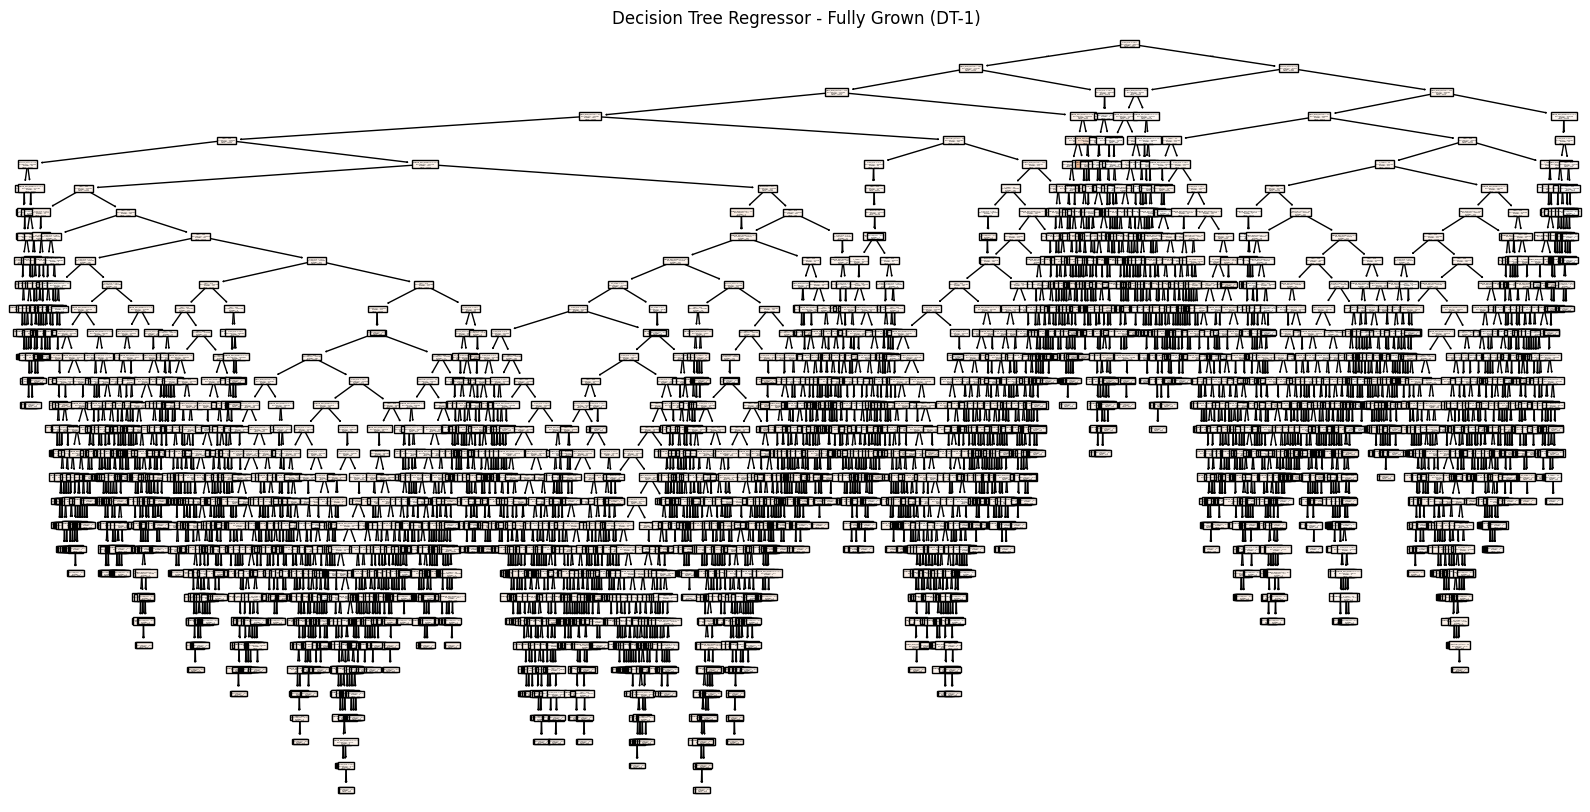

In [25]:
# Visualizing the full Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt1, filled=True, feature_names=X_reg.columns)
plt.title('Decision Tree Regressor - Fully Grown (DT-1)')
plt.show()

In [26]:
# Evaluating DT-1
print("DT-1 Fully Grown Tree Evaluation:")
print("MSE:", mean_squared_error(y_reg_test, y_pred_dt1))
print("MAE:", mean_absolute_error(y_reg_test, y_pred_dt1))
print("R2 Score:", r2_score(y_reg_test, y_pred_dt1))

DT-1 Fully Grown Tree Evaluation:
MSE: 1069.3899006622516
MAE: 25.82864238410596
R2 Score: -1.003838925850563


----------Building Decision Tree 2 (Pruned Tree)-----------

In [27]:
# Pruned Decision Tree Regressor (depth=4)
dt2 = DecisionTreeRegressor(max_depth=4, random_state=42)
dt2.fit(X_reg_train, y_reg_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [28]:
# Predictions with DT-2
y_pred_dt2 = dt2.predict(X_reg_test)

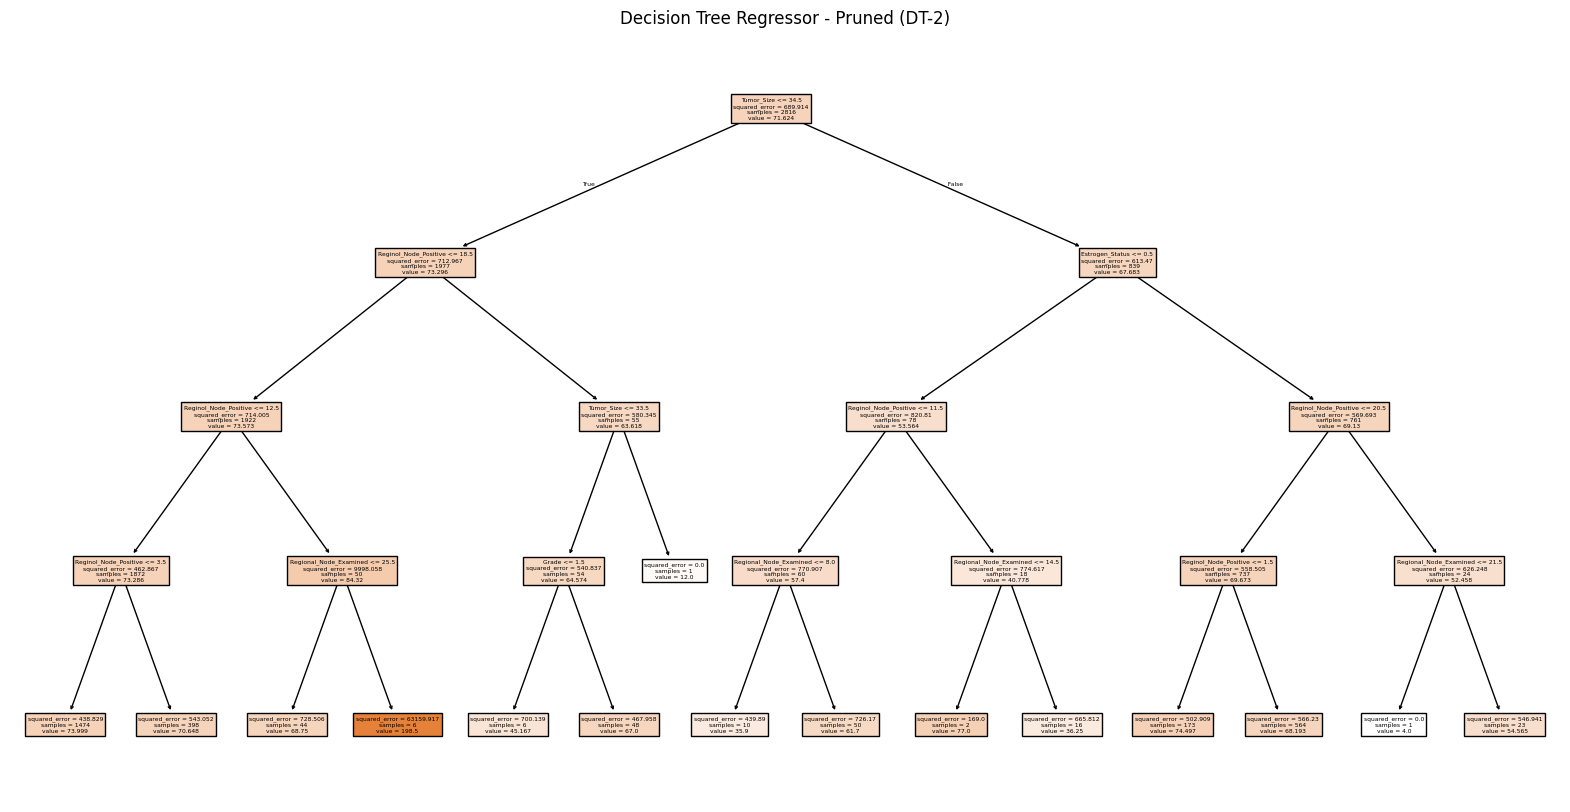

In [29]:
# Visualizing the pruned Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt2, filled=True, feature_names=X_reg.columns)
plt.title('Decision Tree Regressor - Pruned (DT-2)')
plt.show()

In [30]:
# Evaluating DT-2
print("DT-2 Pruned Tree Evaluation:")
print("MSE:", mean_squared_error(y_reg_test, y_pred_dt2))
print("MAE:", mean_absolute_error(y_reg_test, y_pred_dt2))
print("R2 Score:", r2_score(y_reg_test, y_pred_dt2))

DT-2 Pruned Tree Evaluation:
MSE: 562.1558819662164
MAE: 18.73862461272697
R2 Score: -0.053376170826149316


----------Predicting Survival Months for Patient B002565 (Example)--------------

In [31]:
# Numeric-encoded version of Patient B002565 (use real encoding from your X_reg)
patient_B002565 = {
    'Age': 29,
    'Sex': 0,  # Female = 0
    'Occupation': 15,
    'T Stage': 2,  # T3
    'N Stage': 1,  # N1
    '6th Stage': 3,  # IIIC
    'Differentiated': 1,  # Moderately differentiated
    'Grade': 2,
    'A Stage': 1,  # Regional
    'Tumour Size': 41,
    'Estrogen Status': 0,  # Negative
    'Progesterone Status': 1,  # Positive
    'Regional Node Examined': 5,
    'Regional Node Positive': 1
}

In [32]:
# Convert to DataFrame
patient_df = pd.DataFrame([patient_B002565])


In [33]:
# Match feature names and order
patient_df.columns = X_reg.columns
patient_df = patient_df[X_reg.columns]

In [34]:
# Predict using DT-2
predicted_survival_months = dt2.predict(patient_df)
print("Predicted Survival Months for Patient B002565 (using DT-2):", predicted_survival_months[0])

Predicted Survival Months for Patient B002565 (using DT-2): 35.9
